#Create combined pd dataframe
Retrieve both gt for each input benchmark and the results for each model
#Resulting Format
dataset | dataset idx | ground_truth | (prompt/category?) | [ model | modelResult ]
using long-format dataFrame, where each model result is its separate row

In [2]:
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# ─── Project directories ───────────────────────────────────────────────────────
BASE_DIR       = Path('/cluster/project/sachan/pmlr/grounding-vlms')
EVAL_DIR       = Path(BASE_DIR / 'eval')
ANALYSIS_DIR   = Path(EVAL_DIR / 'analysis')
DATA_DIR       = Path(EVAL_DIR / 'data')
RESULTS_DIR    = Path(EVAL_DIR / 'valid_results')
# Ensure analysis folder exists
ANALYSIS_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
import warnings
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Create combined dataframe with error handling and validation
unified = pd.DataFrame()
dataset_counts = {}
model_counts = {}

# Track processing statistics
datasets_processed = 0
datasets_skipped = 0
models_processed = 0

for data_path in DATA_DIR.glob('*_dataset.csv'):
    try:
        dataset_name = data_path.stem.replace('_dataset', '')
        print(f"Processing dataset: {dataset_name}")
        
        # Load dataset with error handling
        try:
            # First check what columns are available in the dataset
            all_columns = pd.read_csv(data_path, nrows=0).columns.tolist()
            
            # Define the columns we want to extract
            required_columns = ['prompt', 'truth', 'label']
            
            # Handle file_name/image_url column variation
            file_column = None
            if 'file_name' in all_columns:
                file_column = 'file_name'
            elif 'image_url' in all_columns:
                file_column = 'image_url'
            else:
                print(f"Warning: Neither 'file_name' nor 'image_url' found in {dataset_name}")
                datasets_skipped += 1
                continue
            
            columns_to_extract = [file_column] + required_columns
            
            # Load the dataset with the correct columns
            df = pd.read_csv(data_path, usecols=columns_to_extract)
            
            # Check if all required columns exist
            missing_columns = [col for col in required_columns if col not in df.columns]
            if missing_columns:
                print(f"Warning: Missing columns in {dataset_name}: {missing_columns}")
                datasets_skipped += 1
                continue
                
            # Rename the file column consistently to file_name
            if file_column != 'file_name':
                df = df.rename(columns={file_column: 'file_name'})
            
            # Create and validate index
            df = df.reset_index(drop=False).rename(columns={'index': 'idx'})
            
            # Check for duplicate indices
            if df['idx'].duplicated().any():
                print(f"Warning: Duplicate indices found in {dataset_name}. Creating new unique indices.")
                df = df.reset_index(drop=True)
                df['idx'] = df.index
            
            df = df.astype({
                'idx': int,
                'file_name': str,
                'prompt': str,
                'truth': int,
                'label': str
            }, errors='raise')  # Catch type conversion errors
            
            df['dataset'] = dataset_name
            dataset_counts[dataset_name] = len(df)
            
        except Exception as e:
            print(f"Error loading dataset {dataset_name}: {str(e)}")
            datasets_skipped += 1
            continue
        
        # Process model results
        model_results = []
        dataset_models_processed = 0
        
        for model_dir in sorted(RESULTS_DIR.iterdir()):
            if not model_dir.is_dir():
                continue
                
            resultFile = model_dir / f'{dataset_name}_results.csv'
            if not resultFile.exists():
                print(f"Information: Results for {dataset_name} not found in {model_dir.name}")
                continue
                
            try:
                rd_df = pd.read_csv(resultFile, usecols=['idx', 'result'])
                
                # Validate model results
                if rd_df.empty:
                    print(f"Warning: Empty results for {model_dir.name} on {dataset_name}")
                    continue
                    
                rd_df['model'] = model_dir.stem
                rd_df = rd_df.astype({
                    'idx': int,
                    'result': int,
                    'model': str
                })
                
                # Check if model indices match dataset indices
                missing_indices = set(df['idx']) - set(rd_df['idx'])
                if missing_indices:
                    print(f"Warning: Model {model_dir.name} is missing {len(missing_indices)} indices for {dataset_name}")
                rd_df = rd_df[rd_df['result']!=-1]  # Filter out invalid results
                
                model_results.append(rd_df)
                dataset_models_processed += 1
                model_counts[model_dir.stem] = model_counts.get(model_dir.stem, 0) + 1
                
            except Exception as e:
                print(f"Error processing {model_dir.name} for {dataset_name}: {str(e)}")
                continue
        
        if model_results:
            # Combine all model results
            all_results = pd.concat(model_results, ignore_index=True)
            
            # Merge with dataset info with appropriate error handling
            try:
                final_df = df.merge(all_results.rename(columns={'result': 'model_result'}), 
                                    on='idx', how='left', validate='one_to_many')
                
                # Add to unified dataframe
                unified = pd.concat([unified, final_df], ignore_index=True)
                models_processed += dataset_models_processed
                datasets_processed += 1
                
            except pd.errors.MergeError as e:
                print(f"Merge error for {dataset_name}: {str(e)}")
        else:
            print(f"No valid model results found for {dataset_name}")
    
    except Exception as e:
        print(f"Unexpected error processing {data_path}: {str(e)}")

# Check if we have data to save
if not unified.empty:
    # Ensure output directory exists
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    
    # Create output path with safeguards
    output_path = RESULTS_DIR / "combinedResults.csv"
    
    # Backup existing file if it exists
    if output_path.exists():
        backup_path = RESULTS_DIR / f"combinedResults_backup.csv"
        os.rename(output_path, backup_path)
        print(f"Existing file backed up to: {backup_path}")
    
    # Save the unified results
    unified.to_csv(output_path, index=False)
    print(f"Combined results saved to: {output_path}")
    
    # Display basic statistics
    print(f"\nSummary Statistics:")
    print(f"Combined dataset size: {len(unified)} rows")
    print(f"Datasets processed successfully: {datasets_processed} of {datasets_processed + datasets_skipped}")
    print(f"Models evaluated: {unified['model'].nunique()} unique models")
    print(f"Total dataset-model combinations: {len(unified)}")
    
    # Show dataset distribution
    print("\nRows per dataset:")
    dataset_distribution = unified.groupby('dataset').size()
    for dataset, count in dataset_distribution.items():
        print(f"  - {dataset}: {count} rows")
        
    # Show model distribution
    print("\nDatasets evaluated by each model:")
    for model, count in model_counts.items():
        print(f"  - {model}: {count} datasets")
else:
    print("Error: No data was processed successfully. No output file created.")


Processing dataset: FSC-147
Processing dataset: GeckoNum
Information: Results for GeckoNum not found in gemini-2.5-pro-preview-05-06
Information: Results for GeckoNum not found in gemma-3-12b-it
Information: Results for GeckoNum not found in gemma-3-27b-it
Information: Results for GeckoNum not found in gemma-3-4b-it
Processing dataset: PixMo_Count
Information: Results for PixMo_Count not found in GPT-4.1
Information: Results for PixMo_Count not found in claude-3.5-haiku
Information: Results for PixMo_Count not found in gemini-2.5-flash-preview-04-17
Information: Results for PixMo_Count not found in gemini-2.5-pro-preview-05-06
Information: Results for PixMo_Count not found in gemma-3-12b-it
Information: Results for PixMo_Count not found in gemma-3-27b-it
Information: Results for PixMo_Count not found in gemma-3-4b-it
Information: Results for PixMo_Count not found in grok-2-vision
Information: Results for PixMo_Count not found in o4-mini
No valid model results found for PixMo_Count
Proc

In [4]:
# Set display options to show all columns in one row
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', 1000)        # Set wide display width
pd.set_option('display.expand_frame_repr', False)  # Prevent wrapping

print(unified.head())

   idx file_name                                    prompt  truth       label  dataset  model_result           model
0    0     2.jpg  How many sea shells are in this picture?      8  sea shells  FSC-147           8.0           GPT-4
1    0     2.jpg  How many sea shells are in this picture?      8  sea shells  FSC-147           7.0        claude-3
2    0     2.jpg  How many sea shells are in this picture?      8  sea shells  FSC-147           8.0        gemini-2
3    0     2.jpg  How many sea shells are in this picture?      8  sea shells  FSC-147           7.0        gemini-2
4    0     2.jpg  How many sea shells are in this picture?      8  sea shells  FSC-147           8.0  gemma-3-12b-it


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_model_accuracies_by_bin(csv_path, bin_width, value_range, log_scale=False, minData=3, output_path='accuracy_plot.pdf'):
    # Unpack the value_range tuple into min_value and max_value
    min_value, max_value = value_range
    
    # Load data
    df = pd.read_csv(csv_path)

    # Ensure numeric types for comparison
    df['truth'] = pd.to_numeric(df['truth'], errors='coerce')
    df['model_result'] = pd.to_numeric(df['model_result'], errors='coerce')

    # Filter out rows with NaNs in numeric columns
    df = df.dropna(subset=['truth', 'model_result'])

    # Filter rows based on the specified value range
    df = df[(df['truth'] >= min_value) & (df['truth'] <= max_value)]

    # Create bin edges based on the range
    bins = np.arange(min_value, max_value + bin_width, bin_width)
    df['bin'] = pd.cut(df['truth'], bins=bins, include_lowest=True)

    # Determine model accuracies, underprediction, and overprediction in each bin
    df['correct'] = df['truth'] == df['model_result']
    df['underprediction'] = df['model_result'] < df['truth']
    df['overprediction'] = df['model_result'] > df['truth']
    
    # Fix: Use a proper way to get both mean and count from 'correct'
    grouped = df.groupby(['model', 'bin'], observed=False).agg({
        'correct': ['mean', 'count'],  # Get both mean and count from correct
        'underprediction': 'mean', 
        'overprediction': 'mean'
    }).reset_index()
    
    # Fix: Flatten the multi-level column index
    grouped.columns = [
        '_'.join(col).rstrip('_') if isinstance(col, tuple) else col 
        for col in grouped.columns.values
    ]
    
    # Pivot the data to plot by model
    pivot_mean = grouped.pivot(index='bin', columns='model', values='correct_mean')
    pivot_under = grouped.pivot(index='bin', columns='model', values='underprediction_mean')
    pivot_over = grouped.pivot(index='bin', columns='model', values='overprediction_mean')
    pivot_count = grouped.pivot(index='bin', columns='model', values='correct_count')

    # Calculate bin centers for plotting
    bin_centers = [(interval.left + interval.right) / 2 for interval in pivot_mean.index]
    # Plotting
    fig, ax = plt.subplots(figsize=(12, 7))
    # Fix deprecated get_cmap warning
    cmap = plt.colormaps['tab10']
    
    # Lists for legend handles and labels
    model_handles = []
    model_labels = []

    for i, model in enumerate(pivot_mean.columns):
        color = cmap(i % cmap.N)
        
        # Copy the data and set NaN for bins with insufficient data
        plot_data = pivot_mean[model].copy()
        plot_under = pivot_under[model].copy()
        plot_over = pivot_over[model].copy()
        mask = pivot_count[model] < minData
        plot_data[mask] = np.nan
        plot_under[mask] = np.nan
        plot_over[mask] = np.nan
        
        # Plot accuracy (solid line)
        acc_line = ax.plot(bin_centers, plot_data,
                label=model,
                marker='o',
                markersize=2,
                linewidth=1,
                color=color)[0]
                
        # Plot underprediction (dotted line)
        ax.plot(bin_centers, plot_under,
                linestyle=':',
                linewidth=1,
                color=color)
                
        # Plot overprediction (dashed line)
        ax.plot(bin_centers, plot_over,
                linestyle='--',
                linewidth=1,
                color=color)
        
        # Add to legend collections
        model_handles.append(acc_line)
        model_labels.append(model)

    # Create a separate legend for line styles
    from matplotlib.lines import Line2D
    
    line_style_handles = [
        Line2D([0], [0], color='gray', lw=2, label='Accuracy (solid)'),
        Line2D([0], [0], color='gray', lw=2, linestyle=':', label='Underprediction (dotted)'),
        Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Overprediction (dashed)')
    ]
    
    # Add main legend for models
    first_legend = ax.legend(model_handles, model_labels, loc='upper right', title="Models")
    
    # Add the second legend for line styles
    ax.add_artist(first_legend)
    ax.legend(handles=line_style_handles, loc='upper left', title="Metrics")

    ax.set_xlabel('Truth Value Bins')
    ax.set_ylabel('Rate')
    ax.set_title(f'Model Performance by Truth Value Bin ({min_value}-{max_value}), Bin Width: {bin_width}')
    ax.grid(True)
    ax.set_ylim(0, 1.05)  # Set y-axis range from 0 to just above 1

    if log_scale:
        ax.set_yscale('log')

    # Adjust x-axis ticks and labels (every 5th bin)
    tick_indices = np.arange(0, len(bin_centers), 5)
    ax.set_xticks([bin_centers[i] for i in tick_indices if i < len(bin_centers)])
    # Format labels to show inclusive bounds [lower, upper]
    ax.set_xticklabels([f"[{interval.left:.0f},{(interval.right-1):.0f}]" 
                        for interval in [pivot_mean.index[i] for i in tick_indices if i < len(bin_centers)]],
                        rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()

plot_model_accuracies_by_bin(
    csv_path=RESULTS_DIR / 'combinedResults.csv',
    bin_width=2,
    value_range=(0, 100),
    log_scale=False,
    minData=10,
    output_path=ANALYSIS_DIR / 'plots' / 'accuracy_plot.pdf'
)
print("Done")



Done


In [7]:
df = pd.read_csv(RESULTS_DIR / 'combinedResults.csv')

# Group by truth, label, AND model
grouped = df.groupby(['truth', 'label', 'model'])

# Store results for sorting
results = []

for name, group in grouped:
    truth, label, model_name = name
    
    # Only include groups with multiple files (same model on different files with same truth/label)
    if group['file_name'].nunique() > 1:
        min_val = group['model_result'].min()
        max_val = group['model_result'].max()
        mean_val = group['model_result'].mean()
        std_val = group['model_result'].std()
        
        # Calculate max deviation from truth
        max_diff = abs(max_val - truth)
        min_diff = abs(min_val - truth)
        max_deviation = max(max_diff, min_diff)
        
        # Calculate variance across files
        variance = group['model_result'].var()
        
        results.append({
            'truth': truth,
            'label': label,
            'model': model_name,
            'max_deviation': max_deviation,
            'variance': variance,
            'min_val': min_val,
            'max_val': max_val,
            'mean_val': mean_val,
            'std_val': std_val,
            'file_count': group['file_name'].nunique(),
            'group_data': group
        })

# Sort by max deviation (highest first)
results.sort(key=lambda x: x['max_deviation'], reverse=True)

# Print the top 10 groups with highest deviation
print("Top 10 truth-label-model combinations with highest deviation:")
for i, item in enumerate(results[:10]):
    print(f"\nGroup {i+1}: Max Deviation = {item['max_deviation']}")
    print(f"Truth: {item['truth']}, Label: {item['label']}, Model: {item['model']}")
    print(f"Files: {item['file_count']} unique files")
    print(f"Min: {item['min_val']}, Max: {item['max_val']}, Mean: {item['mean_val']:.2f}, Std: {item['std_val']:.2f}")
    
    # Show sample results grouped by file
    print("\nResults by file:")
    for file_name, file_group in item['group_data'].groupby('file_name'):
        for _, row in file_group.iterrows():
            deviation = abs(row['model_result'] - item['truth'])
            print(f"  File: {file_name}, Result: {row['model_result']} (deviation: {deviation})")

Top 10 truth-label-model combinations with highest deviation:

Group 1: Max Deviation = 1299999.0
Truth: 1, Label: types, Model: o4-mini
Files: 21 unique files
Min: 0.0, Max: 1300000.0, Mean: 61905.81, Std: 283683.02

Results by file:
  File: VG_100K/2324682.jpg, Result: 1.0 (deviation: 0.0)
  File: train2014/COCO_train2014_000000036059.jpg, Result: 1.0 (deviation: 0.0)
  File: train2014/COCO_train2014_000000038046.jpg, Result: 2.0 (deviation: 1.0)
  File: train2014/COCO_train2014_000000075821.jpg, Result: 1.0 (deviation: 0.0)
  File: train2014/COCO_train2014_000000151892.jpg, Result: 1.0 (deviation: 0.0)
  File: train2014/COCO_train2014_000000166261.jpg, Result: 1.0 (deviation: 0.0)
  File: train2014/COCO_train2014_000000167453.jpg, Result: 1.0 (deviation: 0.0)
  File: train2014/COCO_train2014_000000179454.jpg, Result: 1.0 (deviation: 0.0)
  File: train2014/COCO_train2014_000000202531.jpg, Result: 1300000.0 (deviation: 1299999.0)
  File: train2014/COCO_train2014_000000224178.jpg, Resu

In [8]:
# Parameters
minData = 5 
maxTruth = 20

df = pd.read_csv(RESULTS_DIR / 'combinedResults.csv')
#get rid of too high values (model too inaccurate anyhow here)
df = df[df['truth'] <= maxTruth]

# First calculate counts for each truth-label combination (across all models)
truth_label_counts = df.groupby(['truth', 'label']).size().reset_index(name='count')

# Filter to only include combinations with at least minData values
valid_combinations = truth_label_counts[truth_label_counts['count'] >= minData]

# Apply the filter to the original dataframe
df_filtered = df.merge(valid_combinations[['truth', 'label']], on=['truth', 'label'])

# Group by truth and label (not model) to get aggregate metrics
grouped_by_truth_label = df_filtered.groupby(['truth', 'label'])

# Calculate accuracy metrics across all models for each truth-label combination
label_accuracy = grouped_by_truth_label.apply(lambda g: pd.Series({
    'count': len(g),
    'exact_match_rate': (g['truth'] == g['model_result']).mean(),
    'within_one_rate': (abs(g['truth'] - g['model_result']) <= 1).mean(),
    'mean_abs_error': abs(g['truth'] - g['model_result']).mean(),
    'std_dev': g['model_result'].std(),
    'num_models': g['model'].nunique()  # Count unique models in this group
})).reset_index()

# Sort by truth value for easier analysis
label_accuracy = label_accuracy.sort_values(['truth', 'label'])

print(f"Accuracy metrics aggregated by truth-label combinations (with minimum {minData} samples):")
# Optionally save the results to CSV
output_path = ANALYSIS_DIR / "truth_label_accuracy.csv"
label_accuracy.to_csv(output_path, index=False)
print(f"\nResults saved to: {output_path}")

Accuracy metrics aggregated by truth-label combinations (with minimum 5 samples):

Results saved to: /cluster/project/sachan/pmlr/grounding-vlms/eval/analysis/truth_label_accuracy.csv


/tmp/ipykernel_137841/2022318024.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  label_accuracy = grouped_by_truth_label.apply(lambda g: pd.Series({


Performance comparison plot saved to: /cluster/project/sachan/pmlr/grounding-vlms/eval/analysis/plots/label_performance_by_truth_value.pdf
Performance table saved to: /cluster/project/sachan/pmlr/grounding-vlms/eval/analysis/plots/label_performance_table.pdf


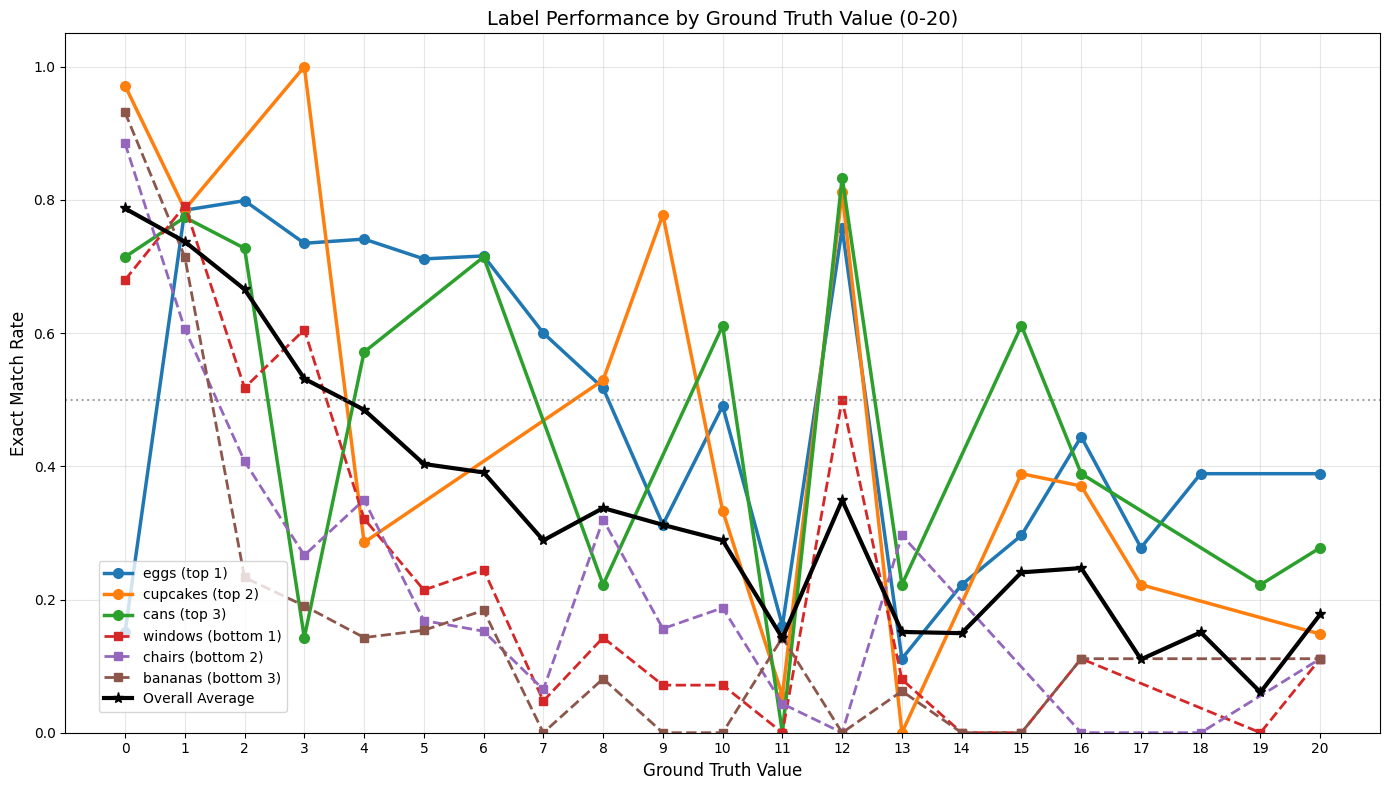

In [9]:
# Create plot directory if it doesn't exist
plots_dir = ANALYSIS_DIR / "plots"
plots_dir.mkdir(exist_ok=True, parents=True)

# Determine total number of possible truth values
possible_truth_values = maxTruth + 1  # 0 to maxTruth inclusive
min_required_coverage = 2*possible_truth_values // 3  # Has at least 2/3 of the truth bins covered

# Count how many different truth values each label has data for
label_truth_coverage = label_accuracy.groupby('label')['truth'].nunique()

# Filter to only include labels with data for at least half of the truth values
valid_labels = label_truth_coverage[label_truth_coverage >= min_required_coverage].index.tolist()

# Calculate overall performance only for valid labels
label_overall_performance = label_accuracy[label_accuracy['label'].isin(valid_labels)].groupby('label')['exact_match_rate'].mean().sort_values(ascending=False)

# Get top 3 and bottom 3 labels from the filtered set for the plot
top_labels = label_overall_performance.head(3).index.tolist()
bottom_labels = label_overall_performance.tail(3).index.tolist()

# Calculate average performance for each truth value across all labels
overall_truth_performance = label_accuracy.groupby('truth')['exact_match_rate'].mean().reset_index()

# Create a new plot
plt.figure(figsize=(14, 8))

# Use positive colors for top performers
top_colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
# Use negative colors for bottom performers
bottom_colors = ['#d62728', '#9467bd', '#8c564b']  # Red, Purple, Brown

# Plot the top 3 performing labels
for i, label in enumerate(top_labels):
    label_data = label_accuracy[label_accuracy['label'] == label].sort_values('truth')
    plt.plot(
        label_data['truth'], 
        label_data['exact_match_rate'],
        color=top_colors[i],
        linestyle='-',
        linewidth=2.5,
        marker='o',
        markersize=7,
        label=f"{label} (top {i+1})"
    )

# Plot the bottom 3 performing labels
for i, label in enumerate(bottom_labels):
    label_data = label_accuracy[label_accuracy['label'] == label].sort_values('truth')
    plt.plot(
        label_data['truth'], 
        label_data['exact_match_rate'],
        color=bottom_colors[i],
        linestyle='--',
        linewidth=2,
        marker='s',
        markersize=6,
        label=f"{label} (bottom {i+1})"
    )

# Plot the overall average performance in black
plt.plot(
    overall_truth_performance['truth'],
    overall_truth_performance['exact_match_rate'],
    color='black',
    linestyle='-',
    linewidth=3,
    marker='*',
    markersize=8,
    label='Overall Average'
)

# Add a horizontal reference line at 50%
plt.axhline(y=0.5, color='gray', linestyle=':', alpha=0.7)

# Set plot properties
plt.xlabel('Ground Truth Value', fontsize=12)
plt.ylabel('Exact Match Rate', fontsize=12)
plt.title(f'Label Performance by Ground Truth Value (0-{maxTruth})', fontsize=14)
plt.grid(True, alpha=0.3)
plt.ylim(0, 1.05)

# Set x-axis to show integer values only
plt.xticks(range(0, maxTruth+1))

# Add legend with better positioning
plt.legend(loc='lower left', bbox_to_anchor=(0.02, 0.02), fontsize=10)

plt.tight_layout()

# Save the plot
output_path = plots_dir / "label_performance_by_truth_value.pdf"
plt.savefig(output_path)
print(f"Performance comparison plot saved to: {output_path}")

# ----- Create a detailed performance table for top and bottom labels -----

# Get top 15 and bottom 15 labels for detailed analysis
top15_labels = label_overall_performance.head(15).index.tolist()
bottom15_labels = label_overall_performance.tail(15).index.tolist()
selected_labels = top15_labels + bottom15_labels

# Create a summary DataFrame with aggregate metrics for these labels
summary_data = []

for label in selected_labels:
    # Get all data for this label
    label_data = label_accuracy[label_accuracy['label'] == label]
    
    # Calculate aggregate metrics
    avg_accuracy = label_data['exact_match_rate'].mean()
    avg_within_one = label_data['within_one_rate'].mean()
    avg_error = label_data['mean_abs_error'].mean()
    avg_std = label_data['std_dev'].mean()
    total_samples = label_data['count'].sum()
    truth_coverage = label_data['truth'].nunique()
    coverage_percent = (truth_coverage / (maxTruth + 1)) * 100
    
    # Store in list
    summary_data.append({
        'label': label,
        'avg_accuracy': avg_accuracy,
        'avg_within_one': avg_within_one,
        'avg_error': avg_error,
        'avg_std': avg_std,
        'total_samples': total_samples,
        'truth_coverage': f"{truth_coverage}/{maxTruth+1} ({coverage_percent:.1f}%)"
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Mark top/bottom labels
summary_df['category'] = 'Middle'
summary_df.loc[summary_df['label'].isin(top15_labels), 'category'] = 'Top'
summary_df.loc[summary_df['label'].isin(bottom15_labels), 'category'] = 'Bottom'

# Sort by category first (top, then bottom), then by accuracy
summary_df['category_order'] = summary_df['category'].map({'Top': 0, 'Bottom': 1, 'Middle': 2})
summary_df = summary_df.sort_values(['category_order', 'avg_accuracy'], ascending=[True, False])
summary_df = summary_df.drop(columns=['category_order'])

# Format the numeric columns
summary_df['avg_accuracy'] = summary_df['avg_accuracy'].map('{:.3f}'.format)
summary_df['avg_within_one'] = summary_df['avg_within_one'].map('{:.3f}'.format)
summary_df['avg_error'] = summary_df['avg_error'].map('{:.2f}'.format)
summary_df['avg_std'] = summary_df['avg_std'].map('{:.2f}'.format)

# Create a figure and axis for the table
fig, ax = plt.subplots(figsize=(12, 12))
ax.axis('off')

# Create the table
table_data = summary_df[['label', 'category', 'avg_accuracy', 'avg_within_one', 'avg_error', 'avg_std', 'total_samples', 'truth_coverage']]
table = ax.table(
    cellText=table_data.values,
    colLabels=['Label', 'Category', 'Accuracy', 'Within ±1', 'Mean Error', 'Std Dev', 'Samples', 'Truth Coverage'],
    loc='center',
    cellLoc='center'
)

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)

# Color the header row
for i in range(len(table_data.columns)):
    table[(0, i)].set_facecolor('#D8E9F0')
    table[(0, i)].set_text_props(weight='bold')

# Color the rows based on category
for i in range(len(table_data)):
    category = table_data.iloc[i]['category']
    if category == 'Top':
        color = '#E5F5E0'  # Light green
    elif category == 'Bottom':
        color = '#FEE0D2'  # Light red
    else:
        color = 'white'
        
    for j in range(len(table_data.columns)):
        table[(i+1, j)].set_facecolor(color)

# Add a title
plt.title('Top and Bottom 15 Label Performance', fontsize=14, y=1.05)

# Save the table as PDF
table_output_path = plots_dir / "label_performance_table.pdf"
plt.tight_layout()
plt.savefig(table_output_path, bbox_inches='tight', pad_inches=0.5)
plt.close()

print(f"Performance table saved to: {table_output_path}")